# MPC Implementation

The MPC has been implemented according to the guidelines of the lesson. The most important differences are the inclusion of a latency and that the waypoints are given in map coordinates.

### Latency

In order to deal with the latency in the actuators, I predict the state (i.e. the position and the direction) in the future and make all the calculations with this projected state. I am assuming that the acceleration of the car is equal to the value of the throttle. It shouldn't be necessarily like that, but in practice it works well. This projection is done in map coordinates, but it could also have been done in vehicule coordinates.

```cpp
// Latency correction in map coordinates.
// Based on the current state, I project the
// future state after latency seconds.
const double latency = 0.1;
v += throttle * latency;
psi -= v * steering_angle * deg2rad(25) / Lf * latency;
px += v * cos(psi) * latency;
py += v * sin(psi) * latency;   
```

### Transformation from map coordinates to vehicle coordinates

The waypoints and the current state is reported by the simulator in map coordinates. On the other hand, the MPC solver equations assume vehicle coordinates. Also, in order to paint the waypoints and the predicted trajectory in the simulator we need to give them in vehicle coordinates.

```cpp
Eigen::MatrixXd mapToCarCoordinates(const Eigen::MatrixXd &pts, double px,
                                    double py, double psi) {
  Eigen::MatrixXd transformed(2, pts.cols());
  double c_psi = cos(psi);
  double s_psi = sin(psi);
  auto t_x = Eigen::MatrixXd::Constant(1, pts.cols(), -px * c_psi - py * s_psi);
  auto t_y = Eigen::MatrixXd::Constant(1, pts.cols(), px * s_psi - py * c_psi);
  transformed.row(0) = 
      pts.row(0) * c_psi + pts.row(1) * s_psi + t_x;
  transformed.row(1) = 
      - pts.row(0) * s_psi + pts.row(1) * c_psi + t_y;
  return transformed;
}  
```

## MPC cost function tuning

In order to select the parameters of the weights of the different cost components, I run several iterations and plot graphs of the actuators, to prevent sudden changes of values (See next section).

Other parameter I have tuned is $N = 20$ (number of steps) and the $\delta_t = 0.05s$

Also, I have changed the maximum steering angle from 25deg to 30deg. The original value was making the vehicle to take the curves closer to the inner part, instead that in the middle of the road. 

```cpp
// The part of the cost based on the reference state.
for (int t = 0; t < N; t++) {
  fg[0] += 2 * CppAD::pow(vars[cte_start + t], 2);
  fg[0] += CppAD::pow(vars[epsi_start + t], 2);
  fg[0] += 20 * CppAD::pow(vars[v_start + t] - ref_v, 2);
}

// Minimize the use of actuators.
for (int t = 0; t < N - 1; t++) {
  fg[0] += CppAD::pow(vars[delta_start + t], 2);
  fg[0] += 20 * CppAD::pow(vars[a_start + t], 2);
}

// Minimize the value gap between sequential actuations.
for (int t = 0; t < N - 2; t++) {
  fg[0] += 30000 * CppAD::pow(vars[delta_start + t + 1] - vars[delta_start + t], 2);
  fg[0] += 1000000 * CppAD::pow(vars[a_start + t + 1] - vars[a_start + t], 2);
}

```


## Analysis of the MPC error

To facilitate the selection of the parameters, I have used pandas to plot the controller error.

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('./dump.csv', header=None, names=['steer', 'throttle'])
df.head()

,steer,throttle
0,-0.010433,1.0
1,-0.252632,1.0
2,-0.450040,1.0
3,-0.395538,1.0
4,-0.406861,1.0


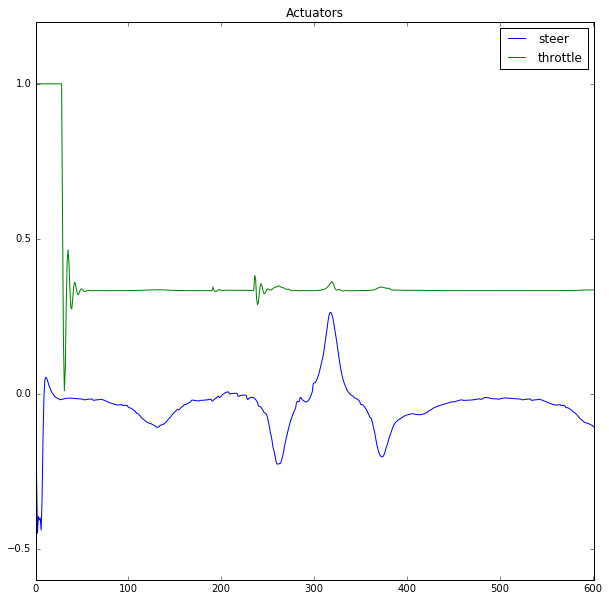

In [14]:
_ = df[:].plot(title="Actuators", figsize=(10,10))

## Video

[Video in YouTube](https://www.youtube.com/watch?v=97c6-XssRp8)